## Capture Fraction Analysis

This problem is an example of a capture fraction analysis based on
Leake and others (2010) using the model developed by Freyberg (1988) and
the MODFLOW API. The MODFLOW API is used because the capture fraction
for each cell can be calculated without regenerating the input files.
The capture fraction perturbation flux is added to the second well (WEL)
package model.


### Initial setup

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl
import shutil
import sys

import flopy
import git
import matplotlib as mpl
import matplotlib.pyplot as plt
import modflowapi
import numpy as np
import pooch
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-capture"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
data_path = root / "data" / sim_name if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "seconds"

# Load the bottom, hydraulic conductivity, and idomain arrays
fname = "bottom.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:201758a5b7febb0390b8b52e634be27f",
)
bottom = np.loadtxt(fpath)
fname = "hydraulic_conductivity.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:6c78564ba92e850d7d51d6e957b8a3ff",
)
k11 = np.loadtxt(fpath)
fname = "idomain.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:435d4490adff7a35d1d4928661e45d81",
)
idomain = np.loadtxt(fpath, dtype=np.int32)

# Model parameters
nper = 1  # Number of periods
nlay = 1  # Number of layers
nrow = 40  # Number of rows
ncol = 20  # Number of columns
delr = 250.0  # Column width ($m$)
delc = 250.0  # Row width ($m$)
top = 35.0  # Top of the model ($m$)
icelltype = 1  # Cell conversion type
strt = 45.0  # Starting head ($m$)
recharge = 1.60000000e-09  # Recharge rate ($m/s$)
cf_q = -1e-3  # Perturbation flux ($m/s$)

# Temporal discretization
tdis_ds = ((1.0, 1.0, 1),)

# Well boundary conditions
wel_spd = {
    0: [
        [0, 8, 15, -0.00820000],
        [0, 10, 12, -0.00410000],
        [0, 19, 13, -0.00390000],
        [0, 25, 9, -8.30000000e-04],
        [0, 28, 5, -7.20000000e-04],
        [0, 33, 11, -0.00430000],
    ]
}

# Constant head boundary conditions
chd_spd = {
    0: [
        [0, 39, 5, 16.90000000],
        [0, 39, 6, 16.40000000],
        [0, 39, 7, 16.10000000],
        [0, 39, 8, 15.60000000],
        [0, 39, 9, 15.10000000],
        [0, 39, 10, 14.00000000],
        [0, 39, 11, 13.00000000],
        [0, 39, 12, 12.50000000],
        [0, 39, 13, 12.00000000],
        [0, 39, 14, 11.40000000],
    ]
}

# River boundary conditions
rbot = np.linspace(20.0, 10.25, num=nrow)
rstage = np.linspace(20.1, 11.25, num=nrow)
riv_spd = []
for idx, (s, b) in enumerate(zip(rstage, rbot)):
    riv_spd.append([0, idx, 14, s, 0.05, b])
riv_spd = {0: riv_spd}

# Solver parameters
nouter = 100
ninner = 25
hclose = 1e-9
rclose = 1e-3

# Create mapping array for the capture zone analysis
imap = idomain.copy()
for _k, i, j, _h in chd_spd[0]:
    imap[i, j] = 0

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models():
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(
        sim_name=sim_name,
        sim_ws=sim_ws,
        exe_name="mf6",
    )
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        linear_acceleration="BICGSTAB",
        outer_maximum=nouter,
        outer_dvclose=hclose * 10.0,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
    )
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=sim_name,
        newtonoptions="NEWTON UNDER_RELAXATION",
    )
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=bottom,
        idomain=idomain,
    )

    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=icelltype,
        k=k11,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=strt)
    flopy.mf6.ModflowGwfriv(gwf, stress_period_data=riv_spd, pname="RIV-1")
    flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel_spd, pname="WEL-1")
    flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)
    flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chd_spd)
    flopy.mf6.ModflowGwfwel(
        gwf,
        maxbound=1,
        pname="CF-1",
        filename=f"{sim_name}.cf.wel",
    )
    flopy.mf6.ModflowGwfoc(
        gwf,
        printrecord=[("BUDGET", "ALL")],
    )
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


def capture_fraction_iteration(mobj, q, inode=None):
    mobj.initialize()
    # time loop
    current_time = mobj.get_current_time()
    end_time = mobj.get_end_time()
    if inode is not None:
        update_wel_pak(mobj, inode, q)
    while current_time < end_time:
        mobj.update()
        current_time = mobj.get_current_time()
    qriv = get_streamflow(mobj)
    mobj.finalize()
    return qriv


def update_wel_pak(mobj, inode, q):
    # set nodelist to inode
    tag = mobj.get_var_address("NODELIST", sim_name, "CF-1")
    nodelist = mobj.get_value(tag)
    nodelist[0] = inode + 1  # convert from zero-based to one-based node number
    mobj.set_value(tag, nodelist)
    # set nbound to 1
    tag = mobj.get_var_address("NBOUND", sim_name, "CF-1")
    nbound = mobj.get_value(tag)
    nbound[0] = 1
    mobj.set_value(tag, nbound)
    # set bound to q
    tag = mobj.get_var_address("Q", sim_name, "CF-1")
    bound = mobj.get_value(tag)
    bound[:] = q
    mobj.set_value(tag, bound)


def get_streamflow(mobj):
    tag = mobj.get_var_address("SIMVALS", sim_name, "RIV-1")
    return mobj.get_value(tag).sum()


@timed
def run_models():
    soext = ".so"
    if sys.platform.lower() == "win32":
        soext = ".dll"
    if sys.platform.lower() == "darwin":
        soext = ".dylib"
    libmf6_path = pl.Path(shutil.which("mf6")).parent / f"libmf6{soext}"
    sim_ws = os.path.join(workspace, sim_name)
    mf6 = modflowapi.ModflowApi(libmf6_path, working_directory=sim_ws)
    qbase = capture_fraction_iteration(mf6, cf_q)

    # create capture fraction array
    capture = np.zeros((nrow, ncol), dtype=float)

    # iterate through each active cell
    ireduced_node = -1
    for irow in range(nrow):
        for jcol in range(ncol):
            # skip inactive cells
            if imap[irow, jcol] < 1:
                continue

            # increment reduced node number
            ireduced_node += 1

            # calculate the perturbed river flow
            qriv = capture_fraction_iteration(mf6, cf_q, inode=ireduced_node)

            # add the value to the capture array
            capture[irow, jcol] = (qriv - qbase) / abs(cf_q)

    # save the capture fraction array
    fpth = os.path.join(sim_ws, "capture.npz")
    np.savez_compressed(fpth, capture=capture)

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (6, 6)


def plot_results(silent=True):
    if not plot:
        return

    if silent:
        verbosity_level = 0
    else:
        verbosity_level = 1

    with styles.USGSMap():
        sim_ws = os.path.join(workspace, sim_name)
        sim = flopy.mf6.MFSimulation.load(
            sim_name=sim_name, sim_ws=sim_ws, verbosity_level=verbosity_level
        )
        gwf = sim.get_model(sim_name)
        wel = gwf.get_package("WEL-1")

        # load the capture fraction data
        fpth = os.path.join(sim_ws, "capture.npz")
        capture = np.load(fpth)["capture"]

        # plot grid
        fig = plt.figure(figsize=(4, 3.75), constrained_layout=True)
        gs = mpl.gridspec.GridSpec(
            2, 2, figure=fig, width_ratios=(4, 1), height_ratios=(1, 6)
        )

        ax = fig.add_subplot(gs[:, 0])
        ax.set_aspect("equal")

        mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
        cf = mm.plot_array(capture, vmin=0, vmax=1)
        mm.plot_grid(lw=0.5, color="0.5")
        mm.plot_bc(package=wel)
        ax.axvline(x=14.5 * delc, lw=1.25, color="cyan")
        mm.plot_bc("CHD", color="green")
        mm.plot_ibound()
        ax.set_ylabel("y-coordinate, in feet")
        ax.set_xlabel("x-coordinate, in feet")
        styles.remove_edge_ticks(ax)

        ax = fig.add_subplot(gs[0, 1])
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_color("none")
        ax.spines["bottom"].set_color("none")
        ax.spines["left"].set_color("none")
        ax.spines["right"].set_color("none")
        ax.patch.set_alpha(0.0)
        cbar = plt.colorbar(cf, ax=ax, orientation="horizontal")
        cbar.ax.set_xlabel("Streamflow capture fraction")
        ax.plot(
            -1000,
            -1000,
            "s",
            ms=5,
            color="green",
            mec="black",
            mew=0.5,
            label="Constant head",
        )
        ax.plot(-1000, -1000, color="cyan", lw=1.25, label="River")
        ax.plot(
            -1000, -1000, "s", ms=5, color="red", mec="black", mew=0.5, label="Well"
        )
        ax.plot(
            -1000,
            -1000,
            "s",
            ms=5,
            color="black",
            mec="black",
            mew=0.5,
            label="Inactive cell",
        )
        styles.graph_legend(ax, ncol=1, frameon=False, loc="upper center")

        if plot_show:
            plt.show()
        if plot_save:
            fig.savefig(figs_path / f"{sim_name}-01.png")

### Running the example

Define and invoke a function to run the example scenario, then plot results.

run_models took 17206.55 ms


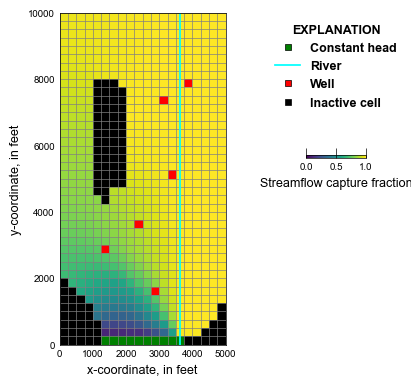

In [5]:
def scenario(silent=True):
    sim = build_models()
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models()


scenario()

if plot:
    # Simulated streamflow capture fraction map for the Freyberg (1988) groundwater flow model.
    plot_results()